In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime, time, requests, json, math
import keras
import tensorflow
import sklearn
from sklearn.utils import shuffle

C:\ProgramData\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Cleaning

In [2]:
def kick_nan(x):
    x = str(x).replace(" ", "").lower()
    if (x == "nan") or (x == "免引水"):
        y = 0
    else:
        y = x
    return y

def get_dummy_column_wanted(df, all_col=[]):
    if len(all_col) > 0:
        for i in all_col:
            df = pd.concat([df, pd.get_dummies(df[i], prefix=[i])], axis=1)
        return df
    else:
        return df

def make_col_be_str(df, str_col=[]):
    if len(str_col) > 0:
        for i in str_col:
            df[i] = df[i].apply(lambda x:str(x))
        return df
    else:
        return df
        
def make_col_be_int(df, int_col=[]):
    if len(int_col) > 0:
        for i in int_col:
            df[i] = df[i].apply(lambda x:int(float(str(x))))
        return df
    else:
        return df

def make_col_be_float(df, float_col=[]):
    if len(float_col) > 0:
        for i in float_col:
            df[i] = df[i].apply(lambda x:float(str(x)))
        return df
    else:
        return df
    
def remove_too_much_data(df, boundary_number, check_col_name):
    count = 0
    work_time_dic = {}
    check_list = list(df[check_col_name])
    for i in set(check_list):
        if i not in work_time_dic:
            work_time_dic[i] = check_list.count(i)
        else:
            pass
        
    df0 = df[df[check_col_name] == min(check_list)]
    del work_time_dic[min(check_list)]
    for i in work_time_dic:
        count+=1
        if work_time_dic[i] < boundary_number:
            df_less = df[df[check_col_name] == i]
#             print(count, df_less.shape)
            df0 = pd.concat([df0, df_less])
        else:
            df_too_much = df[df[check_col_name] == i]
            df_too_much = shuffle(df_too_much).reset_index(drop=True)
            remove_n = work_time_dic[i] - boundary_number
            drop_indices = np.random.choice(df_too_much.index, remove_n, replace=False)
            df_too_much = df_too_much.drop(drop_indices)
#             print(count, df_too_much.shape)
            df0 = pd.concat([df0, df_too_much])
    return df0
    
def data_cleaning():
    # read the file
    df = pd.read_excel("khh1005.xlsx")
    # df = pd.read_excel("船舶作業時間估計_進港靠泊.xlsx")
    # drop useless columns
    df["work_time"] = df["mean_work_time"]
    df = df.drop(["min_work_time", "max_work_time", "mean_work_time", "pilot_ready_time", "min_end_time", "max_end_time", "pilot_ready_time", "place1", "pilot2", "tug2_no", "tug3_no", "pier_info", "seven", "day"], axis=1)
    df = df[df["work_time"]>0]
    # fix the err data (kick out nan)
    for col in df.columns:
        df[col] = df[col].apply(lambda x:str(kick_nan(x)))
    # add features of the month, hour, year
    df["month"] = df["start_time"].apply(lambda x: int(str(x).replace("-", "").replace(":", "")[4:6]))
    df["day"] = df["start_time"].apply(lambda x: int(str(x).replace("-", "").replace(":", "")[6:8]))
    df["hour"] = df["start_time"].apply(lambda x: int(str(x).replace("-", "").replace(":", "")[8:10]))
    df["weekday"] = df["start_time"].apply(lambda x: int(datetime.datetime.strptime(str(x), "%Y-%m-%d%H:%M:%S").weekday()))
    # the datatype should be float
    df = make_col_be_float(df, ['front_weight','back_weight','weight_level','dist','wind'])
    # the datatype should be string 
    df = make_col_be_str(df, ['sailing_status','park','reverse']) #,'start_time'
    # the datatype should be integer
    df = make_col_be_int(df, ['pilot_wait_time', 'work_time', 'ship_no','port','place2','pilot1','tug1_no','tug_cnt','total_weight','avg_hp']) #, "month", "day", "hour"
    # drop useless columns
    df = df.drop(["start_time"], axis=1)
    return df

In [3]:
df = data_cleaning()
print("shape of the df:", df.shape)
print("-"*80)
print("column names:", df.columns)
print("-"*80)
df.head()

shape of the df: (31907, 22)
--------------------------------------------------------------------------------
column names: Index(['ship_no', 'sailing_status', 'pilot_wait_time', 'port', 'place2',
       'pilot1', 'tug1_no', 'tug_cnt', 'total_weight', 'front_weight',
       'back_weight', 'weight_level', 'dist', 'wind', 'park', 'reverse',
       'avg_hp', 'work_time', 'month', 'day', 'hour', 'weekday'],
      dtype='object')
--------------------------------------------------------------------------------


,ship_no,sailing_status,pilot_wait_time,port,place2,pilot1,tug1_no,tug_cnt,total_weight,front_weight,...,dist,wind,park,reverse,avg_hp,work_time,month,day,hour,weekday
0,50091,o,0,1,1066,100,109,1,6094,6.0,...,4968.093286,0.15,o,0,3200,4,1,1,0,6
1,308684,i,4,1,1058,82,321,1,16232,6.0,...,3879.059264,1.00,o,0,3200,52,1,1,1,6
2,46698,i,8,2,1079,74,171,1,27968,10.0,...,1502.675679,1.00,l,0,5200,27,1,1,1,6
3,326585,i,5,2,1102,102,163,2,8562,4.0,...,2785.267130,0.75,o,0,3700,34,1,1,2,6
4,57126,i,5,2,1109,98,172,2,108069,11.5,...,1033.162198,0.75,r,0,5200,26,1,1,2,6


In [4]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation, ensemble, preprocessing, metrics

C:\ProgramData\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
def pre_processing_before_train(df, dm_col, dp_col, pr_col, target_y, pre_meth="method1"):
    if dm_col != []:
        df = get_dummy_column_wanted(df, dm_col)
    else:
        df = df
    y = df[target_y]
    if dp_col+dm_col != []:
        x = df.drop(dp_col+dm_col, axis=1)
    else:
        x = df.drop([target_y], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)
    
    # pre_process scale needed
    if pr_col != []:
        if pre_meth == "method1":
            mean_tra = np.mean(X_train[pr_col], axis=0)
            std_tra = np.std(X_train[pr_col], axis=0)  
            X_train[pr_col] = sklearn.preprocessing.scale(X_train[pr_col])
            X_test[pr_col] = (X_test[pr_col]-mean_tra)/std_tra
            pre_info = ["method1", mean_tra, std_tra]
        elif pre_meth == "method2":
            max_tra = np.max(X_train[pr_col], axis=0)
            min_tra = np.min(X_train[pr_col], axis=0)
            X_train[pr_col] = (X_train[pr_col]-min_tra)/(max_tra-min_tra)
            X_test[pr_col] = (X_test[pr_col]-min_tra)/(max_tra-min_tra)
            pre_info = ["method2", min_tra, max_tra]
    else:
        pre_info = []
    return X_train, X_test, y_train, y_test, pre_info

# processing for status_sailing equal to "i"

the shape of df_1 (14984, 22)
          work_time
count  14762.000000
mean      35.605338
std       10.451078
min        9.000000
25%       27.000000
50%       35.000000
75%       43.000000
max       65.000000


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

,total_weight,weight_level,dist,wind,avg_hp,weekday,['port']_1,['port']_2,['tug_cnt']_1,['tug_cnt']_2,...,['hour']_14,['hour']_15,['hour']_16,['hour']_17,['hour']_18,['hour']_19,['hour']_20,['hour']_21,['hour']_22,['hour']_23
9520,-0.826458,-1.246026,2.670524,-0.326622,-0.914835,3,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21969,2.412037,1.737413,-1.292664,-0.140811,1.128613,2,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4513,-0.141045,0.245694,0.036922,-0.088823,0.684385,3,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
7655,2.103955,1.737413,-0.761607,-0.143504,0.506694,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7810,-0.574206,-0.748786,0.684347,0.169909,-2.646434,5,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


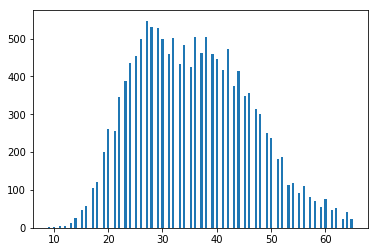

In [6]:
df_1 = df[(df["sailing_status"] == "i")]
print("the shape of df_1", df_1.shape)
print("="*100)

# remove outlier
df_1_bl_p2std = int(np.mean(df_1.work_time) + np.std(df_1.work_time)*2)+1
df_1_bl_n2std = int(np.mean(df_1.work_time) - np.std(df_1.work_time)*2)+1
df_1 = df_1[(df_1.work_time<=df_1_bl_p2std) & (df_1_bl_n2std<df_1.work_time)]
# df_1 = remove_too_much_data(df_1, 300, "work_time")

print(df_1[["work_time"]].describe())
print("="*100)
plt.hist(df_1["work_time"], 140)
print("="*100)

df_1_med = 35

# preprocessing df_1
dm_col_1 = ["port", "tug_cnt", "park", "reverse", "month", "hour"]
dp_col_1 = ["front_weight", "back_weight", "tug1_no", "pilot1", "ship_no", "sailing_status", "work_time", "place2", "day", "pilot_wait_time"]
pr_col_1 = ["dist", "weight_level", "total_weight", "wind", "avg_hp"]
# df_1 = df_1[df_1["port"] == 1]
# df_2 for <= median
X1_train0, X1_test0, y1_train0, y1_test0, pre_info1_0 = pre_processing_before_train(df_1[df_1["work_time"] <= df_1_med], dm_col_1, dp_col_1, pr_col_1, "work_time", "method1")
# df_2 for > median
X1_train1, X1_test1, y1_train1, y1_test1, pre_info1_1 = pre_processing_before_train(df_1[df_1["work_time"] > df_1_med], dm_col_1, dp_col_1, pr_col_1, "work_time", "method1")

# =================================cleaning for classification========================================
dm_col_1c = ["port", "tug_cnt", "park", "reverse", "month", "hour"]
dp_col_1c = ["front_weight", "back_weight", "tug1_no", "pilot1", "ship_no", "sailing_status", "work_time", "place2", "day", "work_time_med", "pilot_wait_time"]
pr_col_1c = ["total_weight", "dist", "weight_level", "wind", "avg_hp"]
df_1["work_time_med"] = df_1["work_time"].apply(lambda x: 0 if x<=df_1_med else 1)
X1_train_c, X1_test_c, y1_train_c, y1_test_c, pre_info1_c = pre_processing_before_train(df_1, dm_col_1c, dp_col_1c, pr_col_1c, "work_time_med", "method1")
from keras.utils import np_utils
y1_train_c = np_utils.to_categorical(y1_train_c, num_classes = 2)
y1_test_c = np_utils.to_categorical(y1_test_c, num_classes = 2)
X1_train_c.head()
# ====================================================================================================

# processing for status_sailing equal to "t"

the shape of df_2 (2010, 22)
         work_time
count  1988.000000
mean     46.901911
std      18.064469
min       5.000000
25%      35.000000
50%      42.000000
75%      55.000000
max     120.000000


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

,total_weight,weight_level,dist,wind,avg_hp,weekday,['port']_0,['port']_1,['port']_2,['port']_3,...,['hour']_14,['hour']_15,['hour']_16,['hour']_17,['hour']_18,['hour']_19,['hour']_20,['hour']_21,['hour']_22,['hour']_23
21644,2.025407,2.061013,-0.929578,0.006025,-2.700872,5,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
12941,-0.289938,-0.384061,1.836990,-0.634520,-0.626752,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11558,-0.380422,-0.384061,-0.487002,-0.500005,0.224606,3,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17494,-0.523425,-0.995330,-0.886359,-0.174929,0.224606,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25210,-0.477670,-0.384061,0.318447,-0.432748,-0.626752,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


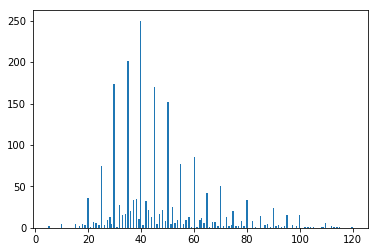

In [7]:
df_2 = df[(df["sailing_status"] == "t")]
print("the shape of df_2", df_2.shape)
print("="*100)

# remove outlier
df_2_bl_p2std = int(np.mean(df_2.work_time) + np.std(df_2.work_time)*2)+1
# df_2_bl_n2std = int(np.mean(df_2.work_time) - np.std(df_2.work_time)*2)+1
df_2 = df_2[(df_2.work_time<=df_2_bl_p2std)]
# df_2 = remove_too_much_data(df_2, 300, "work_time")

print(df_2[["work_time"]].describe())
print("="*100)
plt.hist(df_2["work_time"], 220)
print("="*100)

df_2_med = 42

# preprocessing df_2
dm_col_2 = ["port", "tug_cnt", "park", "month", "hour"]
dp_col_2 = ["front_weight", "back_weight", "tug1_no", "pilot1", "ship_no", "sailing_status", "work_time", "place2", "day", "reverse", "pilot_wait_time"]
pr_col_2 = ["weight_level", "dist", "total_weight", "wind", "avg_hp"]
# df_2 for <= median
X2_train0, X2_test0, y2_train0, y2_test0, pre_info2_0 = pre_processing_before_train(df_2[df_2["work_time"]<=df_2_med], dm_col_2, dp_col_2, pr_col_2, "work_time", "method1")
# df_2 for > median
X2_train1, X2_test1, y2_train1, y2_test1, pre_info2_1 = pre_processing_before_train(df_2[df_2["work_time"]>df_2_med], dm_col_2, dp_col_2, pr_col_2, "work_time", "method1")

# =================================cleaning for classification========================================
dm_col_2c = ["port", "tug_cnt", "park", "month", "hour"]
dp_col_2c = ["front_weight", "back_weight", "ship_no", "pilot1", "sailing_status", "work_time", "place2", "day", "reverse", "work_time_med", "tug1_no", "pilot_wait_time"]
pr_col_2c = ["weight_level", "dist", "total_weight", "wind", "avg_hp"]
df_2["work_time_med"] = df_2["work_time"].apply(lambda x: 0 if x<=df_2_med else 1)
X2_train_c, X2_test_c, y2_train_c, y2_test_c, pre_info2_c = pre_processing_before_train(df_2, dm_col_2c, dp_col_2c, pr_col_2c, "work_time_med", "method1")
from keras.utils import np_utils
y2_train_c = np_utils.to_categorical(y2_train_c, num_classes = 2)
y2_test_c = np_utils.to_categorical(y2_test_c, num_classes = 2)
X2_train_c.head()
# ====================================================================================================

# processing for status_sailing equal to "o"

the shape of df_3 (14913, 22)
          work_time
count  14259.000000
mean      15.424434
std        8.305709
min        1.000000
25%       10.000000
50%       15.000000
75%       20.000000
max       38.000000


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

,total_weight,weight_level,dist,wind,avg_hp,weekday,['port']_1,['port']_2,['tug_cnt']_1,['tug_cnt']_2,...,['hour']_14,['hour']_15,['hour']_16,['hour']_17,['hour']_18,['hour']_19,['hour']_20,['hour']_21,['hour']_22,['hour']_23
18720,0.538392,0.781492,-0.418200,0.093957,-0.257585,2,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10213,-0.251291,0.275016,0.656455,0.506819,-0.613156,3,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
4723,0.085473,0.275016,-0.013227,0.792566,0.097985,6,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
3710,-0.048460,0.275016,0.249795,-0.256914,-0.257585,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
16836,-0.298580,0.275016,-1.213866,0.184213,-0.257585,6,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


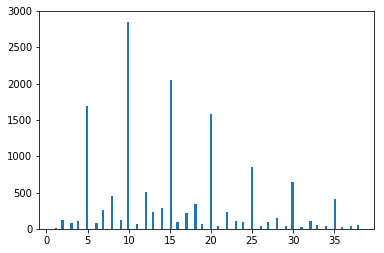

In [8]:
df_3 = df[(df["sailing_status"] == "o")]
print("the shape of df_3", df_3.shape)
print("="*100)

# remove outlier
df_3_bl_p2std = int(np.mean(df_3.work_time) + np.std(df_3.work_time)*2)+1
# df_3_bl_n2std = int(np.mean(df_3.work_time) - np.std(df_3.work_time)*2)+1
df_3 = df_3[(df_3.work_time<=df_3_bl_p2std)]
# df_3 = df_3[(df_3.work_time<=30)]
# df_3 = remove_too_much_data(df_3, 300, "work_time")

# factor is 5
# df_3_for_5 = df_3[df_3["work_time"]%5 != 0]

print(df_3[["work_time"]].describe())
print("="*100)
plt.hist(df_3["work_time"], 135)
print("="*100)

df_3_med = 15

# preprocessing
dm_col_3 = ["port", "tug_cnt", "park", "month", "hour"]
dp_col_3 = ["front_weight", "back_weight","pilot1", "tug1_no", "ship_no", "sailing_status", "work_time", "place2", "day", "reverse", "pilot_wait_time"]
pr_col_3 = ["total_weight", "dist", "weight_level", "wind", "avg_hp"]
# df_3 for <= median
X3_train0, X3_test0, y3_train0, y3_test0, pre_info3_0 = pre_processing_before_train(df_3[df_3["work_time"]<=df_3_med], dm_col_3, dp_col_3, pr_col_3, "work_time", "method1")
# df_3 for > median
X3_train1, X3_test1, y3_train1, y3_test1, pre_info3_1 = pre_processing_before_train(df_3[df_3["work_time"]>df_3_med], dm_col_3, dp_col_3, pr_col_3, "work_time", "method1")

# =================================cleaning for classification========================================
dm_col_3c = ["port", "tug_cnt", "park", "month", "hour"]
dp_col_3c = ["front_weight", "back_weight", "pilot1", "tug1_no", "ship_no", "sailing_status", "work_time", "place2", "day", "reverse", "work_time_med", "pilot_wait_time"]
pr_col_3c = ["total_weight", "dist", "weight_level", "wind", "avg_hp"]
df_3["work_time_med"] = df_3["work_time"].apply(lambda x: 0 if x<=df_3_med else 1)
X3_train_c, X3_test_c, y3_train_c, y3_test_c, pre_info3_c = pre_processing_before_train(df_3, dm_col_3c, dp_col_3c, pr_col_3c, "work_time_med", "method1")
from keras.utils import np_utils
y3_train_c = np_utils.to_categorical(y3_train_c, num_classes = 2)
y3_test_c = np_utils.to_categorical(y3_test_c, num_classes = 2)
X3_train_c.head()
# ====================================================================================================

# Training: Classification (Random Forest)

In [9]:
from sklearn import cross_validation, ensemble, preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier

In [10]:
clf1 = RandomForestClassifier(max_depth=30, n_estimators=200,random_state=0, n_jobs=20)
clf2 = RandomForestClassifier(max_depth=40, n_estimators=200,random_state=0, n_jobs=20)
clf3 = RandomForestClassifier(max_depth=35, n_estimators=200,random_state=0, n_jobs=20)

In [11]:
clf1.fit(X1_train_c, y1_train_c)
clf2.fit(X2_train_c, y2_train_c)
clf3.fit(X3_train_c, y3_train_c)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=20,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
accuracy1 = metrics.accuracy_score(y1_test_c, clf1.predict(X1_test_c))
print("accuracy for df_1 classification", accuracy1)
accuracy2 = metrics.accuracy_score(y2_test_c, clf2.predict(X2_test_c))
print("accuracy for df_2 classification", accuracy2)
accuracy3 = metrics.accuracy_score(y3_test_c, clf3.predict(X3_test_c))
print("accuracy for df_3 classification", accuracy3)

accuracy for df_1 classification 0.8320352184219438
accuracy for df_2 classification 0.7236180904522613
accuracy for df_3 classification 0.7776998597475456


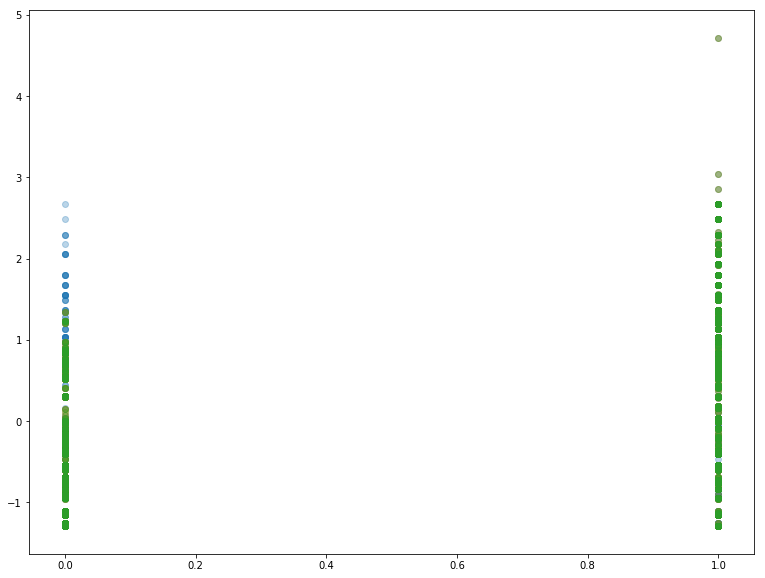

In [13]:
%matplotlib inline
plt.figure(figsize = (13,10))
dist = X1_test_c["dist"]
plt.scatter(y1_test_c[:, 1], dist, alpha = 0.3)
plt.scatter(clf1.predict(X1_test_c)[:, 1], dist, alpha = 0.3)
plt.scatter(clf1.predict(X1_test_c)[:, 1], dist, alpha = 0.3)
plt.show()
# ans = y1_test_c[:, 1] - clf1.predict(X1_test_c)[:, 1]
# ansli = []
# for i in ans:
#     ansli.append(np.abs(i))
# print(ansli.count(0))
# print(ansli.count(1))
# plt.scatter(ansli, dist, alpha = 0.3)
# plt.show()

# Training: Regression (Random Forest)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
regr1_0 = RandomForestRegressor(max_depth=25, random_state=0,n_estimators=100, n_jobs=10)
regr2_0 = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=200, n_jobs=10)
regr3_0 = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=100, n_jobs=10)
regr1_1 = RandomForestRegressor(max_depth=25, random_state=0,n_estimators=100, n_jobs=10)
regr2_1 = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=200, n_jobs=10)
regr3_1 = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=100, n_jobs=10)

In [15]:
regr1_0.fit(X1_train0, y1_train0)
regr1_1.fit(X1_train1, y1_train1)
regr2_0.fit(X2_train0, y2_train0)
regr2_1.fit(X2_train1, y2_train1)
regr3_0.fit(X3_train0, y3_train0)
regr3_1.fit(X3_train1, y3_train1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [16]:
print(regr1_0)
print(regr1_1)
print(regr2_0)
print(regr2_1)
print(regr3_0)
print(regr3_1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=10,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
   

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
print(df_1[df_1["work_time"] <= df_1_med]["work_time"].mean())
print("mse for df_1 <= median:", mean_squared_error(y1_test0, regr1_0.predict(X1_test0)))
print("mae for df_1 <= median:", mean_absolute_error(y1_test0, regr1_0.predict(X1_test0)))
print("-"*80)
print(df_1[df_1["work_time"]> df_1_med]["work_time"].mean())
print("mse for df_1 > median:", mean_squared_error(y1_test1, regr1_1.predict(X1_test1)))
print("mae for df_1 > median:", mean_absolute_error(y1_test1, regr1_1.predict(X1_test1)))
print("-"*80)
df_1["work_time"].describe()

27.237377049180328
mse for df_1 <= median: 15.958535931510069
mae for df_1 <= median: 3.195883596764335
--------------------------------------------------------------------------------
44.5454672831722
mse for df_1 > median: 30.99898424589197
mae for df_1 > median: 4.408124309962539
--------------------------------------------------------------------------------


count    14762.000000
mean        35.605338
std         10.451078
min          9.000000
25%         27.000000
50%         35.000000
75%         43.000000
max         65.000000
Name: work_time, dtype: float64

In [19]:
print("mse for df_2 <= median:", mean_squared_error(y2_test0, regr2_0.predict(X2_test0)))
print("mae for df_2 <= median:", mean_absolute_error(y2_test0, regr2_0.predict(X2_test0)))
print(df_2[df_2["work_time"] <= df_2_med]["work_time"].mean())
print("-"*80)
print("mse for df_2 > median:", mean_squared_error(y2_test1, regr2_1.predict(X2_test1)))
print("mae for df_2 > median:", mean_absolute_error(y2_test1, regr2_1.predict(X2_test1)))
print(df_2[df_2["work_time"] > df_2_med]["work_time"].mean())
print("-"*80)
df_2["work_time"].describe()

mse for df_2 <= median: 34.8979814515625
mae for df_2 <= median: 4.518913749999999
33.59519038076152
--------------------------------------------------------------------------------
mse for df_2 > median: 148.25105202020202
mae for df_2 > median: 8.99060606060606
60.316161616161615
--------------------------------------------------------------------------------


count    1988.000000
mean       46.901911
std        18.064469
min         5.000000
25%        35.000000
50%        42.000000
75%        55.000000
max       120.000000
Name: work_time, dtype: float64

In [20]:
print("mse for df_3 <= median:", mean_squared_error(y3_test0, regr3_0.predict(X3_test0)))
print("mae for df_3 <= median:", mean_absolute_error(y3_test0, regr3_0.predict(X3_test0)))
print(df_3[df_3["work_time"] <= df_3_med]["work_time"].mean())
print("-"*80)
print("mse for df_3 > median:", mean_squared_error(y3_test1, regr3_1.predict(X3_test1)))
print("mae for df_3 > median:", mean_absolute_error(y3_test1, regr3_1.predict(X3_test1)))
print(df_3[df_3["work_time"] > df_3_med]["work_time"].mean())
print("-"*80)
df_3["work_time"].describe()

mse for df_3 <= median: 12.45942817927171
mae for df_3 <= median: 2.898605042016807
10.04795518207283
--------------------------------------------------------------------------------
mse for df_3 > median: 24.66467586754139
mae for df_3 > median: 3.982563573883162
24.420509936257968
--------------------------------------------------------------------------------


count    14259.000000
mean        15.424434
std          8.305709
min          1.000000
25%         10.000000
50%         15.000000
75%         20.000000
max         38.000000
Name: work_time, dtype: float64

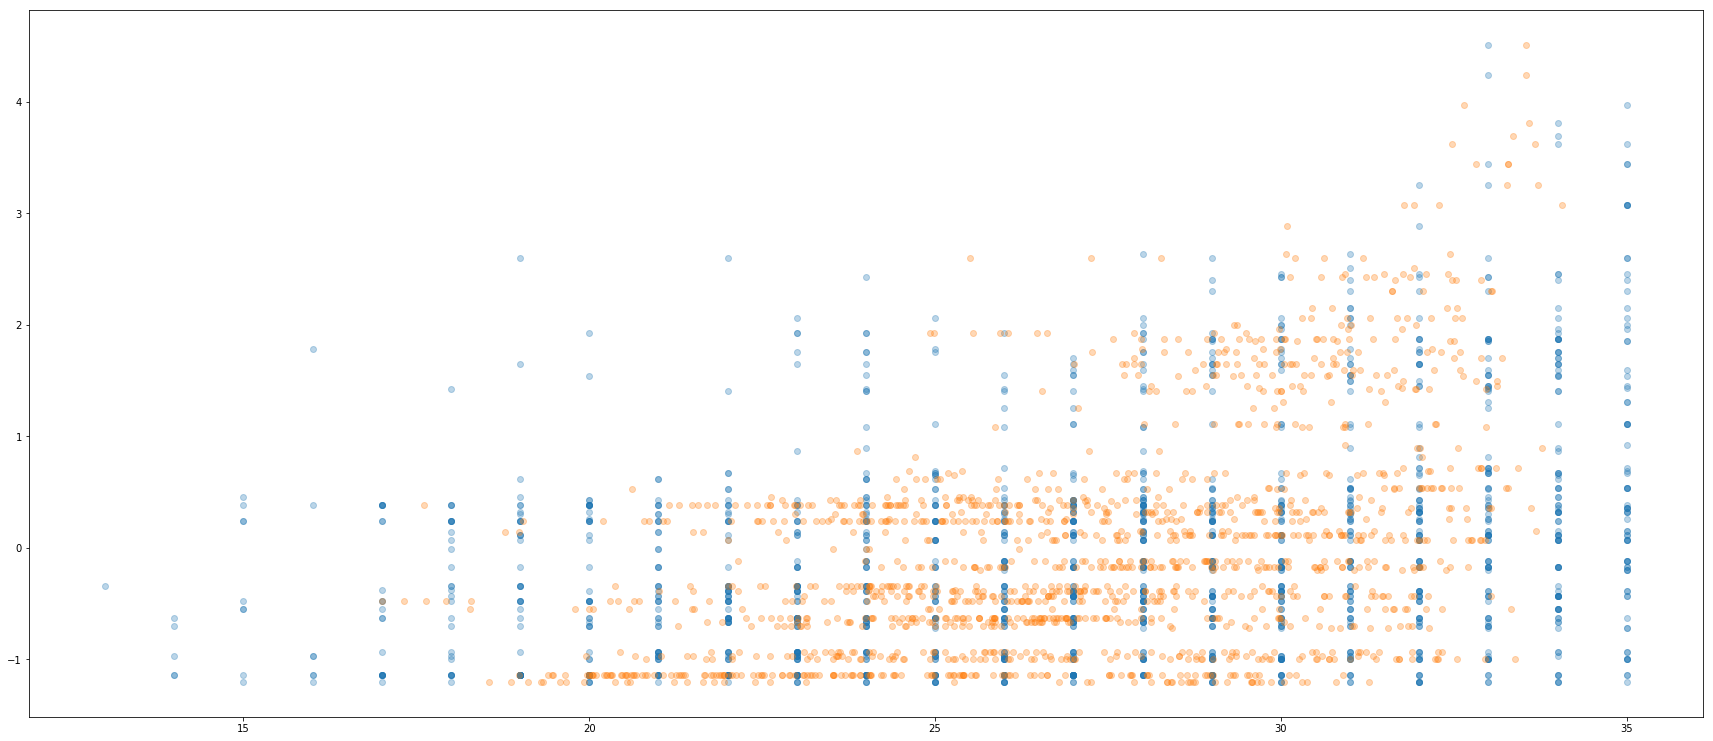

In [21]:
%matplotlib inline
plt.figure(figsize = (30,13))
dist = list(X1_test0["dist"])
plt.scatter(list(y1_test0), dist, alpha = 0.3)
plt.scatter(list(regr1_0.predict(X1_test0)), dist, alpha = 0.3)
plt.show()

# All Output File

In [22]:
# all preprocessing coefficient 
print(pre_info1_c)
print("-"*100)
print(pre_info2_c)
print("-"*100)
print(pre_info3_c)
print("-"*100)
print(pre_info1_1)
print("-"*100)
print(pre_info1_0)
print("-"*100)
print(pre_info2_0)
print("-"*100)
print(pre_info2_1)
print("-"*100)
print(pre_info3_1)
print("-"*100)
print(pre_info3_0)

['method1', total_weight    26241.891185
dist             2050.292450
weight_level        3.505885
wind                3.040403
avg_hp           3429.691337
dtype: float64, total_weight    30556.785480
dist             1335.505028
weight_level        2.011101
wind                6.553156
avg_hp           1125.548973
dtype: float64]
----------------------------------------------------------------------------------------------------
['method1', weight_level        2.628302
dist             2544.904026
total_weight    14621.770440
wind                2.830267
avg_hp           2988.943396
dtype: float64, weight_level        1.635942
dist             2028.764717
total_weight    19517.173757
wind                4.460488
avg_hp            939.675505
dtype: float64]
----------------------------------------------------------------------------------------------------
['method1', total_weight    25371.850004
dist             2092.295834
weight_level        3.457000
wind                2.935129
av

In [23]:
# all model 
print('classification for status "i"')
print(clf1.feature_importances_)
print("-"*100)
print('classification for status "t"')
print(clf2.feature_importances_)
print("-"*100)
print('classification for status "o"')
print(clf3.feature_importances_)
print("="*100)
print('regression for status "i" for <= median')
print(regr1_0.feature_importances_)
print("-"*100)
print('regression for status "i" for > median')
print(regr1_1.feature_importances_)
print("-"*100)
print('regression for status "t" for <= median')
print(regr2_0.feature_importances_)
print("-"*100)
print('regression for status "t" for > median')
print(regr2_1.feature_importances_)
print("-"*100)
print('regression for status "o" for <= median')
print(regr3_0.feature_importances_)
print("-"*100)
print('regression for status "o" for > median')
print(regr3_1.feature_importances_)

classification for status "i"
[1.52864319e-01 7.07478408e-02 2.94166117e-01 7.50886426e-02
 4.68005027e-02 4.25626087e-02 2.08674802e-02 2.52997179e-02
 2.12250132e-02 1.69960506e-02 2.66037267e-03 1.15031129e-04
 8.35636397e-03 8.00483391e-03 8.41870655e-03 6.88014396e-03
 7.32694227e-03 7.44682715e-03 6.70530588e-03 7.49323244e-03
 7.50424387e-03 7.20932440e-03 7.31722781e-03 6.91556189e-03
 7.05650078e-03 7.35819186e-03 6.64873473e-03 7.84369661e-03
 6.87313684e-03 3.08117377e-03 3.20892184e-03 3.50911140e-03
 3.08997205e-03 2.42602937e-03 2.78349334e-03 6.11947418e-03
 8.57031446e-03 6.88284098e-03 5.71729180e-03 5.37332913e-03
 4.90456326e-03 5.11504915e-03 4.65116511e-03 4.73475587e-03
 4.81250655e-03 4.57014176e-03 4.70428294e-03 4.59208335e-03
 4.25835180e-03 3.72127555e-03 3.43149134e-03 3.40321546e-03
 1.58649438e-03]
----------------------------------------------------------------------------------------------------
classification for status "t"
[1.12040315e-01 3.39846393e-0